In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("banudeep/nthuddd2")

print("Path to dataset files:", path)

c:\Users\luizc\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\luizc\.cache\kagglehub\datasets\banudeep\nthuddd2\versions\1


In [2]:
import tensorflow as tf
import os
import pathlib
import numpy as np
from sklearn.model_selection import train_test_split

IMAGE_SIZE = (224, 224)
SEQ_LENGTH = 10   # Tamanho da sequência para a LSTM
BATCH_SIZE = 4    # Batch pequeno para economizar memória (4 vídeos de 10 frames = 40 imgs)
AUTOTUNE = tf.data.AUTOTUNE


DATASET_DIR = r"C:\Users\luizc\.cache\kagglehub\datasets\banudeep\nthuddd2\versions\1"

print(f"Processando dataset em: {DATASET_DIR}")

def find_and_group_sequences(root_dir):
    all_seqs = []
    all_lbls = []
    for current_folder, dirs, files in os.walk(root_dir):

        images = [f for f in files if f.lower().endswith('.jpg')]
        
        if len(images) >= SEQ_LENGTH:
            images = sorted(images) 
            folder_lower = current_folder.lower()
            label = None
            
            if "notdrowsy" in folder_lower:
                label = 0 # Alerta
            elif "drowsy" in folder_lower:
                label = 1 # Fadiga
            
            if label is not None:
                full_paths = [os.path.join(current_folder, img) for img in images]
                
                current_folder_seqs = []
                for i in range(0, len(full_paths) - SEQ_LENGTH + 1, SEQ_LENGTH):
                    window = full_paths[i : i + SEQ_LENGTH]
                    if len(window) == SEQ_LENGTH:
                        current_folder_seqs.append(window)
                        all_lbls.append(label)
                
                all_seqs.extend(current_folder_seqs)

    return all_seqs, all_lbls


all_sequences, all_labels = find_and_group_sequences(DATASET_DIR)

print(f"TOTAL ENCONTRADO:")
print(f"Sequências Totais (Vídeos de 10 frames): {len(all_sequences)}")
print(f"Fadiga (Label 1): {all_labels.count(1)}")
print(f"Alerta (Label 0): {all_labels.count(0)}")


if len(all_sequences) == 0:
    raise ValueError("Nenhuma sequência encontrada! Verifique o caminho.")

train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_sequences, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

def load_single_image(path):
    file_content = tf.io.read_file(path)
    image = tf.io.decode_jpeg(file_content, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.keras.applications.resnet_v2.preprocess_input(image)
    return image

def load_video_sequence(sequence_paths, label):
    video = tf.map_fn(load_single_image, sequence_paths, dtype=tf.float32)
    return video, label


#erro de memoria remover a linha cache

train_dataset = (
    train_ds
    .map(load_video_sequence, num_parallel_calls=AUTOTUNE)
    #.cache() 
    .shuffle(500)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

validation_dataset = (
    val_ds
    .map(load_video_sequence, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    #.cache() 
    .prefetch(AUTOTUNE)
)

print("Dataset NTHU-DDD carregado")

Processando dataset em: C:\Users\luizc\.cache\kagglehub\datasets\banudeep\nthuddd2\versions\1
TOTAL ENCONTRADO:
Sequências Totais (Vídeos de 10 frames): 6652
Fadiga (Label 1): 3603
Alerta (Label 0): 3049
Instructions for updating:
Use fn_output_signature instead
Dataset NTHU-DDD carregado


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

IMAGE_SIZE = 224
CHANNELS = 3
SEQ_LENGTH = 10  # deve ser igual ao usado na preparação dos dados (10 frames)
NUM_CLASSES = 1  # Binário (Fadiga ou Alerta)

#extrator de caracteristicas
#usando a resnet50v2 porem ela so processa UMA imagem por vez, o TimeDistributed vai lidar com o vídeo depois

def build_cnn_base():
    base_model = tf.keras.applications.ResNet50V2(
        include_top=False, 
        weights='imagenet', 
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
    )
    base_model.trainable = False 
    
   
    cnn_input = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    x = base_model(cnn_input)
    x = layers.GlobalAveragePooling2D()(x) 
    
    return models.Model(inputs=cnn_input, outputs=x, name="ResNet_Feature_Extractor")

cnn_extractor = build_cnn_base()

# entrada: "vídeo" com 10 frames
video_input = layers.Input(shape=(SEQ_LENGTH, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# TimeDistributed aplica a cnn_extractor em CADA UM dos 10 frames individualmente
# Entrada: (Batch, 10, 224, 224, 3) -> Saída: (Batch, 10, 2048)
encoded_frames = layers.TimeDistributed(cnn_extractor)(video_input)

# LSTM
x = layers.LSTM(64, return_sequences=False)(encoded_frames) 
# return_sequences=False: UMA decisão final após ver os 10 frames.

x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='sigmoid')(x)

model_hibrido = models.Model(inputs=video_input, outputs=outputs, name="ResNet_LSTM_Network")

#Learning Rate baixo (1e-4) porque a arquitetura é complexa
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_hibrido.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

model_hibrido.summary()

Model: "ResNet_LSTM_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 2048)       │    23,564,800 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       540,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,105,793 (91.96 MB)

 Trainable params: 540,993 (2.06 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [4]:
print("Iniciando treinamento...")

history_hibrido = model_hibrido.fit(
    train_dataset,          
    epochs=10,              
    validation_data=validation_dataset
)

Iniciando treinamento...
Epoch 1/10
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 901s 657ms/step - accuracy: 0.7754 - loss: 0.4616 - recall: 0.8140 - val_accuracy: 0.8603 - val_loss: 0.3176 - val_recall: 0.9764
Epoch 2/10
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 916s 688ms/step - accuracy: 0.8839 - loss: 0.2732 - recall: 0.9087 - val_accuracy: 0.8873 - val_loss: 0.2377 - val_recall: 0.9057
Epoch 3/10
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 920s 690ms/step - accuracy: 0.9066 - loss: 0.2221 - recall: 0.9230 - val_accuracy: 0.9076 - val_loss: 0.2066 - val_recall: 0.9196
Epoch 4/10
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 924s 693ms/step - accuracy: 0.9167 - loss: 0.2001 - recall: 0.9323 - val_accuracy: 0.8843 - val_loss: 0.3225 - val_recall: 0.9986
Epoch 5/10
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 924s 694ms/step - accuracy: 0.9246 - loss: 0.1778 - recall: 0.9382 - val_accuracy: 0.9467 - val_loss: 0.1428 - val_recall: 0.9626
Epoch 6/10
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 930s 698ms/step - accuracy: 0.9323 - loss: 0.1584 - recall: 0.9445 - val_

In [5]:
import os
import pickle
import tensorflow as tf

MODELS_DIR = "saved_models"
HISTORIES_DIR = "historicos"
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(HISTORIES_DIR, exist_ok=True)

model_filename = 'modelo_hibrido_cnn_lstm.keras'
history_filename = 'history_hibrido_cnn_lstm.pkl'

model_path = os.path.join(MODELS_DIR, model_filename)

model_hibrido.save(model_path) 

history_path = os.path.join(HISTORIES_DIR, history_filename)
with open(history_path, 'wb') as file:
    pickle.dump(history_hibrido.history, file)

loaded_model = tf.keras.models.load_model(model_path)
target_output = None

for layer in loaded_model.layers:
    if isinstance(layer, tf.keras.layers.LSTM):
        print(f"Camada LSTM encontrada: '{layer.name}'")
        target_output = layer.output
        break

if target_output is None:
    print("Aviso: Camada LSTM não encontrada pelo tipo. Pegando a saída da penúltima camada.")
    target_output = loaded_model.layers[-2].output

feature_extractor = tf.keras.Model(
    inputs=loaded_model.input,
    outputs=target_output,
    name="Extrator_Temporal_LSTM"
)

feature_extractor.summary()

Camada LSTM encontrada: 'lstm'


Model: "Extrator_Temporal_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 2048)       │    23,564,800 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       540,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,105,728 (91.96 MB)

 Trainable params: 540,928 (2.06 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

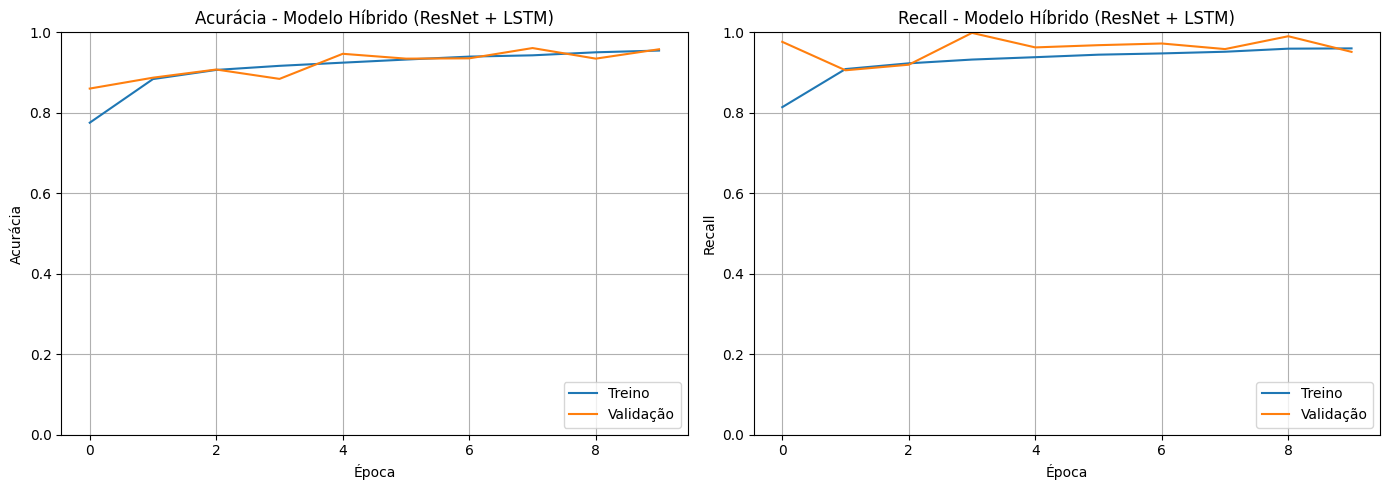


--- Métricas Finais no Dataset de Validação ---
333/333 - 155s - 467ms/step - accuracy: 0.9579 - loss: 0.1017 - recall: 0.9515

Loss (Erro): 0.1017
Acurácia Final: 95.79%
Recall Final: 95.15%


In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 5))
#gráfico 1 - acurácia
plt.subplot(1, 2, 1)
plt.title("Acurácia - Modelo Híbrido (ResNet + LSTM)")
plt.plot(history_hibrido.history['accuracy'], label='Treino')
plt.plot(history_hibrido.history['val_accuracy'], label='Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.ylim([0, 1]) # Ajustei para 0 a 1 para ver o contexto todo
plt.legend(loc='lower right')
plt.grid(True)

#gráfico 2 - recall
plt.subplot(1, 2, 2)
plt.title("Recall - Modelo Híbrido (ResNet + LSTM)")
plt.plot(history_hibrido.history['recall'], label='Treino')
plt.plot(history_hibrido.history['val_recall'], label='Validação')
plt.xlabel('Época')
plt.ylabel('Recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()
print("\n--- Métricas Finais no Dataset de Validação ---")

# O evaluate retorna 3 valores porque foi compilado com: loss, accuracy, recall
val_loss, val_acc, val_recall = model_hibrido.evaluate(validation_dataset, verbose=2)

print(f"\nLoss (Erro): {val_loss:.4f}")
print(f"Acurácia Final: {val_acc * 100:.2f}%")
print(f"Recall Final: {val_recall * 100:.2f}%")

Realizando previsões no conjunto de validação...
333/333 ━━━━━━━━━━━━━━━━━━━━ 177s 501ms/step


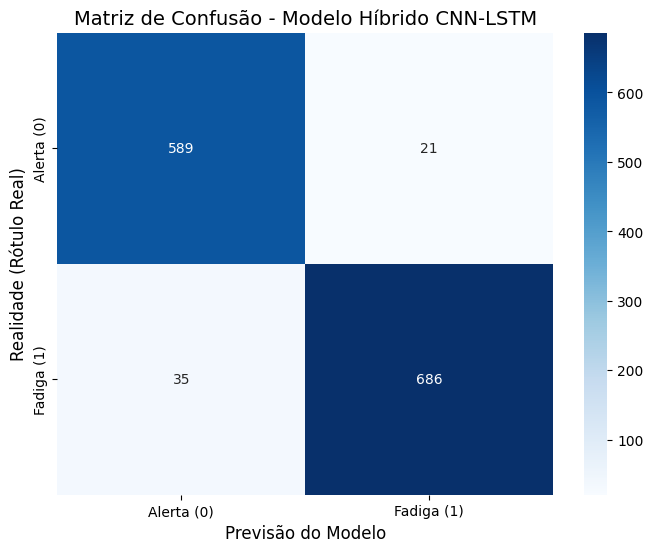


--- Relatório de Métricas Detalhado ---
              precision    recall  f1-score   support

  Alerta (0)       0.94      0.97      0.95       610
  Fadiga (1)       0.97      0.95      0.96       721

    accuracy                           0.96      1331
   macro avg       0.96      0.96      0.96      1331
weighted avg       0.96      0.96      0.96      1331



In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ==============================================================================
# 1. OBTER AS PREVISÕES DO MODELO
# ==============================================================================
print("Realizando previsões no conjunto de validação...")

# O predict retorna probabilidades (ex: 0.1, 0.9, 0.45...)
y_pred_probs = model_hibrido.predict(validation_dataset)

# Convertemos probabilidades em Classes (0 ou 1)
# Se for maior que 0.5, é Fadiga (1). Se menor, é Alerta (0).
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

# ==============================================================================
# 2. OBTER OS RÓTULOS REAIS (TRUE LABELS)
# ==============================================================================
# Precisamos extrair os labels verdadeiros de dentro do dataset do TensorFlow
y_true = np.concatenate([y for x, y in validation_dataset], axis=0)

# ==============================================================================
# 3. GERAR A MATRIZ DE CONFUSÃO
# ==============================================================================
# Calcula a matriz
cm = confusion_matrix(y_true, y_pred_classes)

# Define os nomes das classes para o gráfico
class_names = ['Alerta (0)', 'Fadiga (1)']

# Plota o gráfico (Heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Previsão do Modelo', fontsize=12)
plt.ylabel('Realidade (Rótulo Real)', fontsize=12)
plt.title('Matriz de Confusão - Modelo Híbrido CNN-LSTM', fontsize=14)
plt.show()

# ==============================================================================
# 4. RELATÓRIO DE CLASSIFICAÇÃO DETALHADO
# ==============================================================================
print("\n--- Relatório de Métricas Detalhado ---")
print(classification_report(y_true, y_pred_classes, target_names=class_names))